# Compare resolution obtained with different map densities

## Scope 

- This NB computes XY maps using run 6973 and varying map density (25 x 25, 50 x 50, 100 x 100 bins)

- Run 6973. Feburary 2019. Low background run, closed castle, no sources, 7.7 kV, ENRICHED XENON, high krypton rate, new DAQ


### Author:  JJGC

### Software: KrCalib : https://github.com/nextic/ICAROS/

## Imports

In [265]:
import time
print("Last updated on ", time.asctime())

Last updated on  Fri Mar  1 11:20:49 2019


In [270]:
run_number  = 6973
file_range  = 0, 5813

input_path  = f"$IC_DATA/kdst"
output_path = f"$IC_DATA/dst"
log_path    = f"$IC_DATA/log"
trigger     = 'trigger1'
tags        = 'v0.9.9_20190111_krbg'

bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"
write_filtered_dst = True

In [267]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
import sys
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob
import warnings
import seaborn as sns
sns.set()

In [27]:
from numpy import pi, sqrt

In [20]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units

In [21]:
import krcal.dev.corrections                  as corrections 
import krcal.utils.hst_extend_functions       as hst
from krcal.core import fit_functions_ic       as fitf
import invisible_cities.reco.corrections      as corrf

In [107]:
from krcal.core.core_functions                import time_delta_from_time
from krcal.core.core_functions                import phirad_to_deg
from krcal.core.core_functions                import NN
from krcal.core.core_functions                import timeit
from krcal.core.core_functions                import data_frames_are_identical

from krcal.core.io_functions                  import filenames_from_paths
from krcal.core.io_functions                  import filenames_from_list
from krcal.core.io_functions                  import kdst_write
from krcal.core.io_functions                  import write_maps
from krcal.core.io_functions                  import read_maps
from krcal.core.io_functions                  import write_maps_ts
from krcal.core.io_functions                  import read_maps_ts

from krcal.core.ranges_and_bins_functions     import kr_ranges_and_bins

from krcal.core.histo_functions               import h1, h1d, h2, h2d, profile1d, plot_histo
from krcal.core.kr_types                      import PlotLabels, FitType

from krcal.core.s1s2_functions                import s1d_from_dst
from krcal.core.s1s2_functions                import s2d_from_dst
from krcal.core.s1s2_functions                import plot_s1histos
from krcal.core.s1s2_functions                import plot_s2histos
from krcal.core.s1s2_functions                import energy_time_profile
from krcal.core.s1s2_functions                import energy_X_profile

from krcal.core.plt_functions                 import plot_xy_density
from krcal.core.plt_functions                 import plot_s1_vs_z
from krcal.core.plt_functions                 import plot_s2_vs_z
from krcal.core.plt_functions                 import plot_s2_vs_s1
from krcal.core.plt_functions                 import plot_q_vs_s2
from krcal.core.plt_functions                 import plot_energy_distributions
from krcal.core.plt_functions                 import plot_energy_vs_t

from krcal.core.selection_functions           import event_map_df
from krcal.core.selection_functions           import select_rphi_sectors_df
from krcal.core.selection_functions           import select_xy_sectors_df
from krcal.core.selection_functions           import get_time_series_df
from krcal.core.fitmap_functions              import time_fcs_df
from krcal.core.fitmap_functions              import fit_fcs_in_rphi_sectors_df
from krcal.core.fitmap_functions              import fit_map_xy_df

from krcal.core.map_functions                 import tsmap_from_fmap
from krcal.core.map_functions                 import amap_from_tsmap
from krcal.core.map_functions                 import relative_errors
from krcal.core.map_functions                 import amap_average
from krcal.core.map_functions                 import amap_max
from krcal.core.map_functions                 import amap_min
from krcal.core.map_functions                 import amap_replace_nan_by_mean
from krcal.core.map_functions                 import amap_replace_nan_by_zero
from krcal.core.map_functions                 import regularize_maps
from krcal.core.map_functions                 import get_maps_from_tsmap
from krcal.core.map_functions                 import map_average
from krcal.core.map_functions                 import add_mapinfo

from krcal.core.xy_maps_functions             import draw_xy_maps
from krcal.core.xy_maps_functions             import draw_xy_map
from krcal.core.xy_maps_functions             import draw_xy_maps_ts

from krcal.core.rphi_maps_functions           import draw_rphi_maps
from krcal.core.rphi_maps_functions           import draw_rphi_map
from krcal.core.rphi_maps_functions           import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions           import draw_wedges
from krcal.core.rphi_maps_functions           import define_rphi_sectors
from krcal.core.rphi_maps_functions           import rphi_sector_map_def

from krcal.core.correction_functions          import e0_rphi_correction
from krcal.core.correction_functions          import e0_xy_correction
from krcal.core.correction_functions          import lt_xy_correction
from krcal.core.correction_functions          import e0_xy_correction_ts
from krcal.core.correction_functions          import lt_xy_correction_ts
from krcal.core.correction_functions          import lt_rphi_correction
from krcal.core.correction_functions          import lt_rphi_correction_ts
from krcal.core.correction_functions          import e0_rphi_correction_ts
from krcal.core.correction_functions          import e0_rphi_correction_ts

from krcal.core.fit_lt_histograms             import plot_time_fcs
from krcal.core.fit_energy_functions          import fit_energy
from krcal.core.fit_energy_functions          import plot_fit_energy
from krcal.core.fit_energy_functions          import print_fit_energy
from krcal.core.fit_energy_functions          import resolution_r_z
from krcal.core.fit_energy_functions          import plot_resolution_r_z

### Logger

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [28]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')
log = logging.getLogger()

2019-03-01 09:36:50,467 | INFO : Hello world!


### Input/output 

In [271]:
input_dst_filenames, output_dst_filename, log_filename = filenames_from_paths(run_number,
                                                                              input_path,
                                                                              output_path,
                                                                              log_path,
                                                                              trigger,
                                                                              tags,
                                                                              file_range)
                                                                              
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"log file   = {log_filename}")                       

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6973/kdst_0000_6973_trigger1_v0.9.9_20190111_krbg.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6973/kdst_5812_6973_trigger1_v0.9.9_20190111_krbg.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6973_trigger1_0000_5812.h5
log file   = /Users/jjgomezcadenas/Projects/ICDATA/log/log_6973_trigger1_0000_5812.h5


In [272]:
dst_full           = load_dsts(input_dst_filenames, "DST", "Events")

In [273]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 1797337 
Total number of events: 1570699


In [274]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [275]:
ntot = len(dst_full)
print(f"length of dst = {ntot}")

length of dst = 1797337


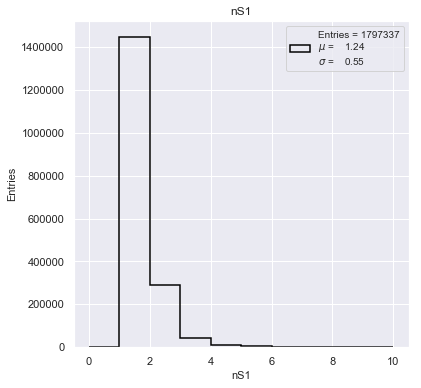

In [276]:
n, b, _, _ = h1d(dst_full.nS1.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS1', y='Entries', title='nS1'))

In [277]:
fnS1 = n[n.argmax()]/np.sum(n)
print(f'fraction of S1s = {fnS1}')

fraction of S1s = 0.8053247665852313


In [475]:
dst1s1 = dst_full[in_range(dst_full.nS1, 1,2)]

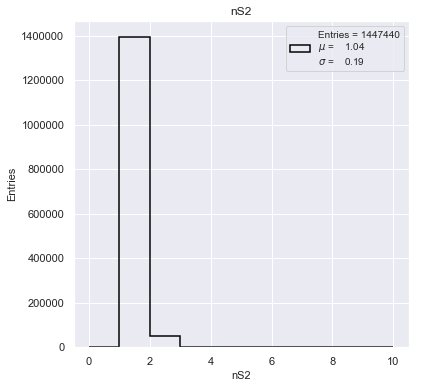

In [279]:
n, b, _, _ = h1d(dst1s1.nS2.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS2', y='Entries', title='nS2'))

In [280]:
fnS2 = n[n.argmax()]/np.sum(n)
print(f'fraction of S2s = {fnS2}')

fraction of S2s = 0.9642264964350854


In [476]:
dst    = dst1s1[in_range(dst1s1.nS2, 1, 2)]

In [282]:
n_full   = len(dst)
eff = n_full   / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {n_full}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 1395660: selection eff = 0.7765154781768806 


In [283]:
s1d = s1d_from_dst(dst)

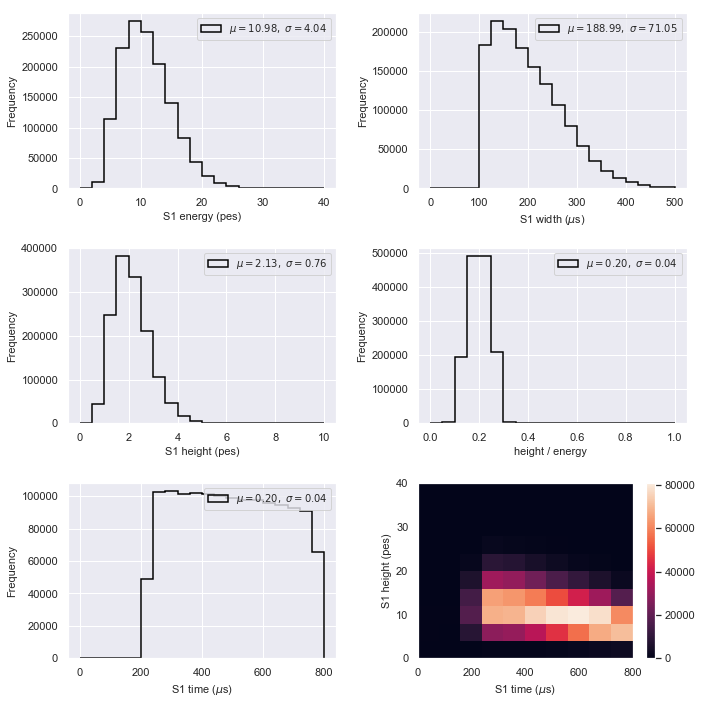

In [284]:
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

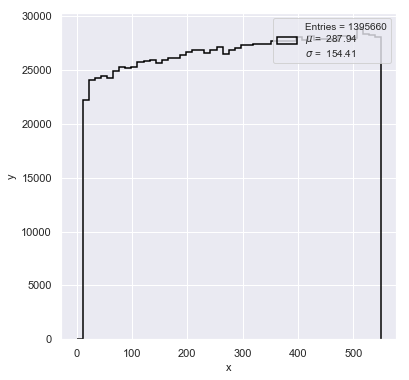

In [285]:
(_) = h1d(dst.Z, bins = 50, range =(0,550))

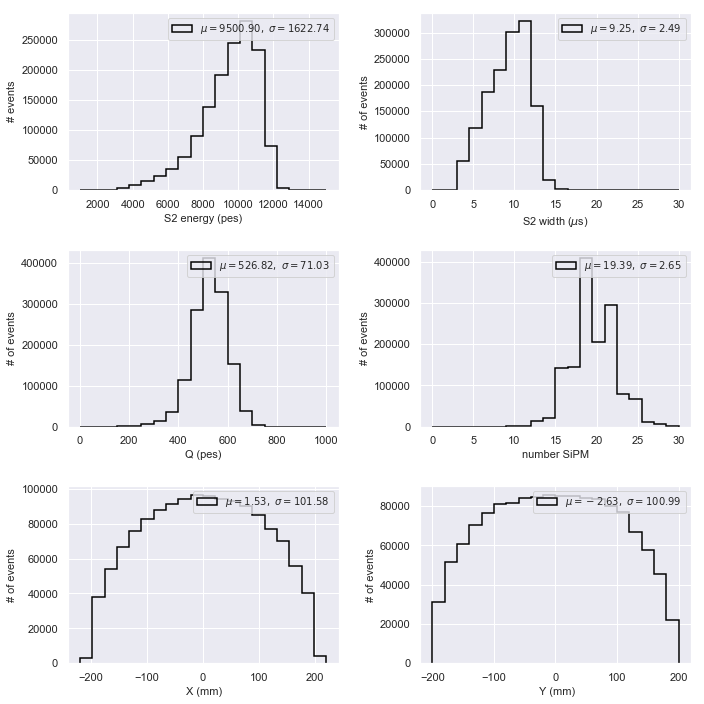

In [286]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### Ranges and binning

In [477]:
RMAX      = 200
RFID      = 180
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 15000)
lt_range = (1000, 9000)
c2_range = (0,5)
time_bins = 5

## 25 x 25 bins for map

In [478]:
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 25,
                                                        ynbins    = 25,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [479]:
krRanges

KrRanges(S2e=(2000, 14000), S1e=(3, 25), S2q=(200, 800), X=(-200, 200), Y=(-200, 200), Z=(10, 550), T=(1551297309.246, 1551373166.558))

In [480]:
krNbins

KrNBins(S2e=25, S1e=10, S2q=25, X=25, Y=25, Z=15, T=21)

### Sort DST in time and add DT column (DT is a vector of time differences)

In [481]:
dst     = dst[dst.R < RMAX]
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)
dst = dst.assign(DT=DT)
dst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [482]:
dst2 = dst

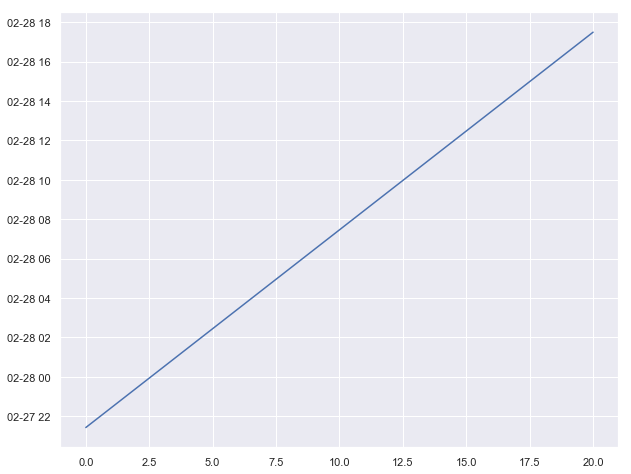

In [483]:
plt.plot(krTimes.timeStamps)

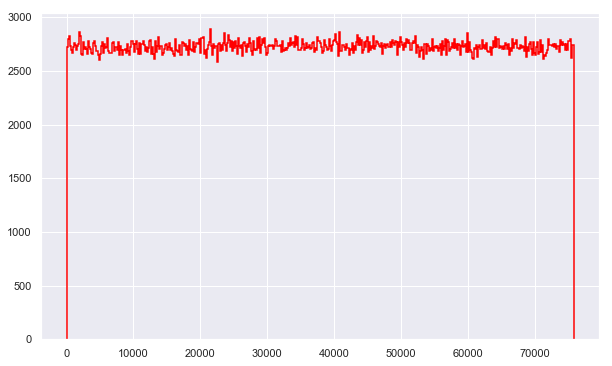

In [484]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(dst.DT.values, bins=500, range = (dst.DT.values[0], dst.DT.values[-1]), color='red', stats=False, lbl='pre-sel')

### Event distribution

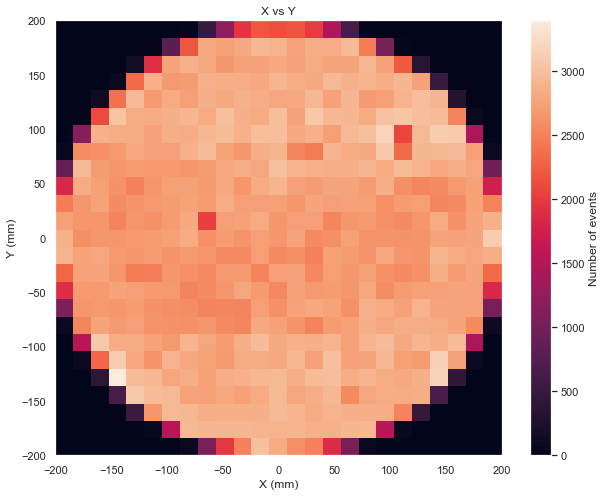

In [401]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

### Fit lifetime of the time series in the fiducial volume ( R < 180 cm) 

In [339]:
dstfid = dst[in_range(dst.R, 0, RFID)]

## Time series

In [340]:
ti = timeit(get_time_series_df)
ts, masks = ti(time_bins, (DT[0],DT[-1]), dstfid)

Time spent in get_time_series_df: 0.008872270584106445 s


In [341]:
ti = timeit(time_fcs_df)
fps = ti(ts, masks, dstfid, 
         nbins_z = 15,
         nbins_e = 25,
         range_z = (10, 550),
         range_e = (7000, 18000),
         energy  = 'S2e',
         fit     = FitType.profile)  # fps: fit-profile series (implicit is a time series, using profile)

Time spent in time_fcs_df: 0.24586796760559082 s


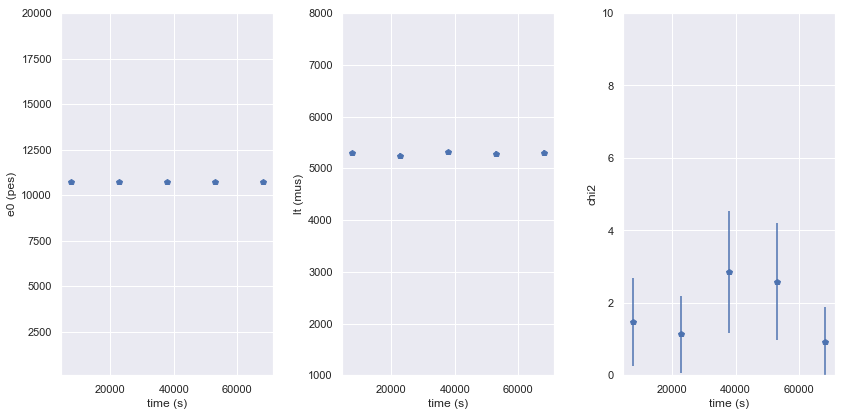

In [342]:
plot_time_fcs(fps,
              range_chi2  = (0,10),
              range_e0    = (100,20000),
              range_lt    = (1000, 8000),
              figsize     = (12,6))

## Divide chamber in sectors of XY

In [343]:
log.setLevel(logging.INFO) # turn to DEBUG to follow progress of this part 

In [402]:
ti = timeit(select_xy_sectors_df)
KXY = ti(dst, krBins.X, krBins.Y)

Time spent in select_xy_sectors_df: 1.5452678203582764 s


In [403]:
nXY = event_map_df(KXY)

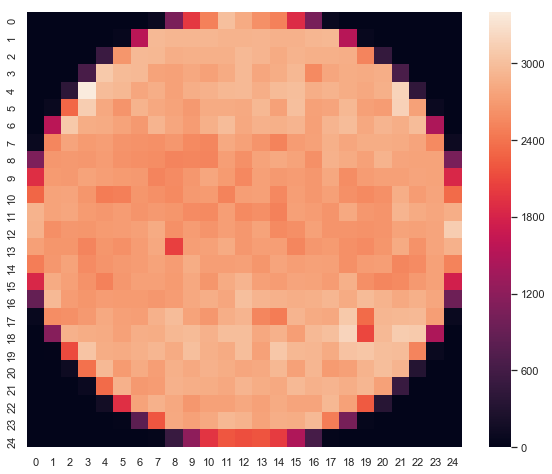

In [404]:
ax = sns.heatmap(nXY, square=True)

## Fits in XY sectors

## Maps

#### The first step is to fit a map XY (in time series) for the number of time bins required (in this case 1)

In [405]:
#log.setLevel(logging.DEBUG)

In [408]:
ti = timeit(fit_map_xy_df)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy = ti(selection_map = KXY,
              event_map      = nXY,
              n_time_bins    = 1,
              time_diffs     = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy         = 'S2e',
              z              = 'Z',
              fit            = FitType.unbined,
              n_min          = 100)

Time spent in fit_map_xy_df: 2.056267023086548 s


#### The second step is to obtain the maps themselves from the fit-map-XY

In [409]:
ti = timeit(tsmap_from_fmap)
tsm = ti(fmxy)

Time spent in tsmap_from_fmap: 0.0005791187286376953 s


#### Third step: select the corresponding map in the time series (in this case just one, ts=0)

In [410]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [411]:
log.setLevel(logging.INFO)

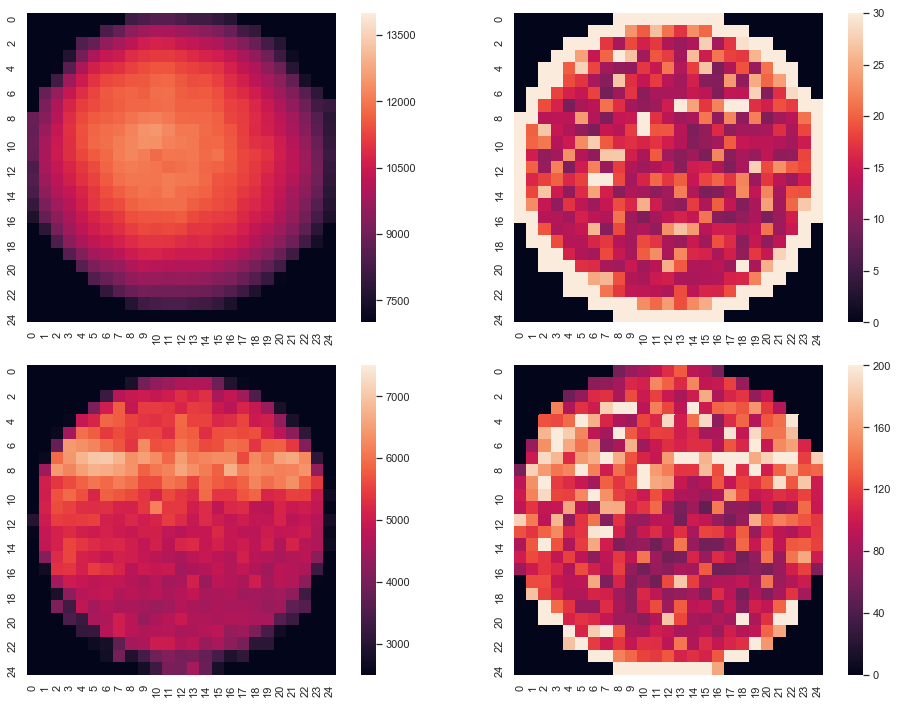

In [412]:
draw_xy_maps(am,
            e0lims  = (7000, 14000),
            ltlims  = (2500, 7500),
            eulims  = (0.0,  30),
            lulims  = (0, 200),
            figsize=(14,10))

#### Am contains the maps in XY bins for the single time series (ts=0). We can now compute the map average, draw, etc:

In [413]:
amap_average(am) 

ASectorMap(chi2=1.2056924317171491, e0=9911.700176658214, lt=4523.829971678841, e0u=27.888611007527498, ltu=126.56053456949286, mapinfo=None)

#### Get rid of outlayers that distort mean and error

In [414]:
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range)

2019-03-02 12:28:53,257 | INFO :  set nans to average value of interval = 10000.0
2019-03-02 12:28:53,285 | INFO :  set nans to average value of interval = 5000.0


In [415]:
amap_average(rmap)

ASectorMap(chi2=1.2056924317171491, e0=9911.700176658214, lt=4540.092620785318, e0u=27.888611007527498, ltu=126.25246405528551, mapinfo=None)

In [416]:
asm = relative_errors(rmap)

In [417]:
amv = amap_average(asm)
amv

ASectorMap(chi2=1.2056924317171491, e0=9911.700176658214, lt=4540.092620785318, e0u=0.3242565797187773, ltu=3.1380515653797523, mapinfo=None)

#### Draw the maps using default colormap

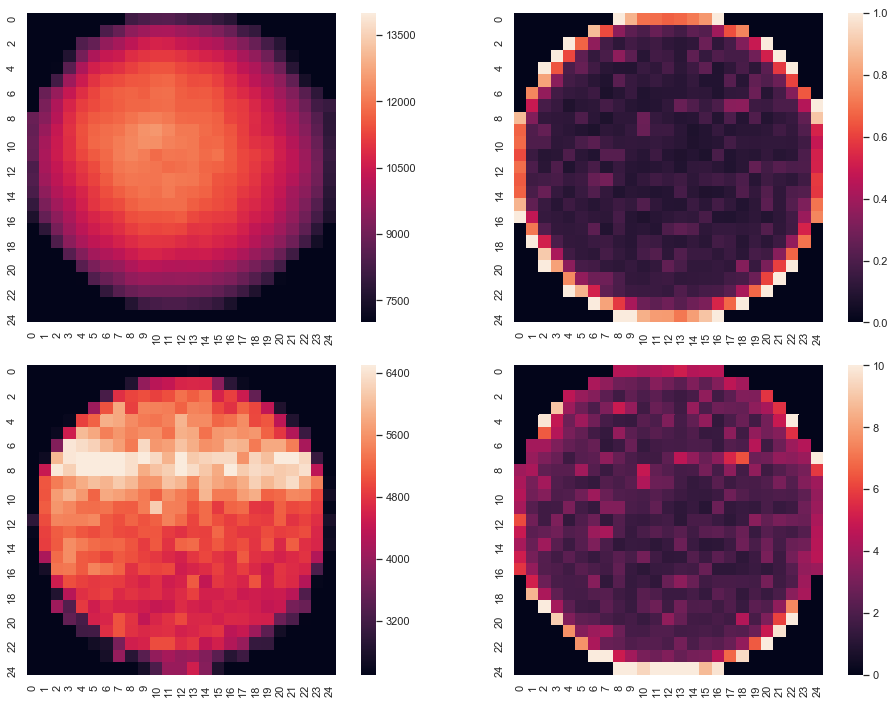

In [418]:
draw_xy_maps(asm,
            e0lims  = (7000, 14000),
            ltlims  = (2500, 6500),
            eulims  = (0.0,  1),
            lulims  = (0, 10),
            figsize=(14,10))

In [419]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

In [420]:
amap_average(asmAv)

ASectorMap(chi2=1.1866129834481027, e0=10068.978176364795, lt=4660.9401734453895, e0u=0.2959175638183715, ltu=3.0097164596152646, mapinfo=None)

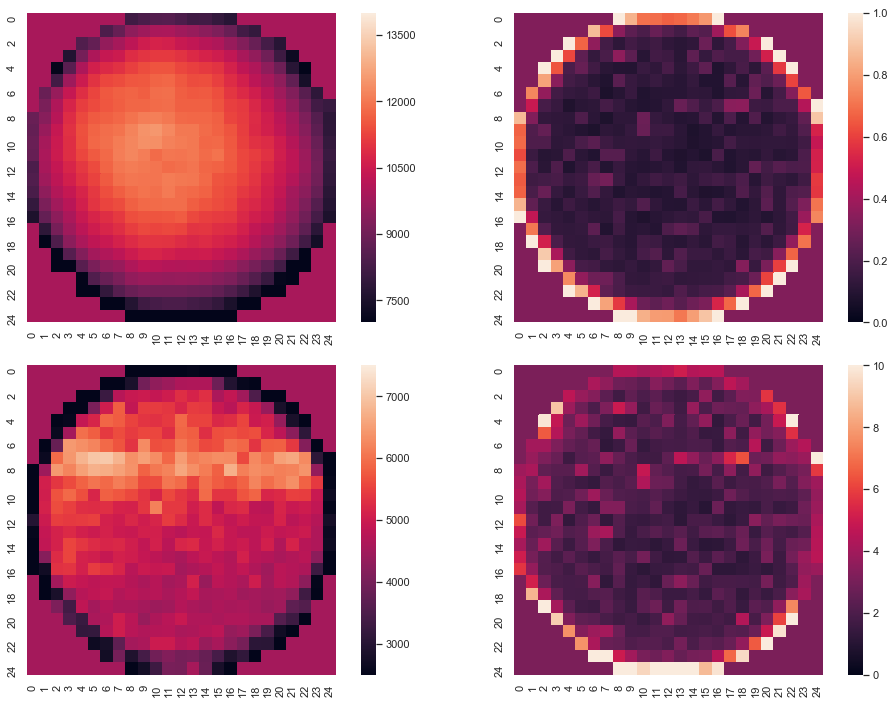

In [421]:
draw_xy_maps(asmAv,
            e0lims  = (7000, 14000),
            ltlims  = (2500, 7500),
            eulims  = (0.0,  1),
            lulims  = (0, 10),
            figsize=(14,10))

In [422]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number=-6400)

In [423]:
asm.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              25
ny              25
run_number   -6400
dtype: int64

### Keep map names as emaps

In [424]:
emaps = asm

## Now check the corrections that can be achieved with the single maps

In [425]:
amap_average(emaps)

ASectorMap(chi2=1.1866129834481027, e0=10068.978176364795, lt=4660.9401734453895, e0u=0.2959175638183715, ltu=3.0097164596152646, mapinfo=None)

In [426]:
norm = amap_max(emaps)

In [427]:
norm

ASectorMap(chi2=3.3520900240910994, e0=12496.545525273503, lt=7038.77428640075, e0u=3.9097413495382694, ltu=20.699640471033327, mapinfo=None)

#### E0 correction:

In [428]:
ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 12.388556957244873 s


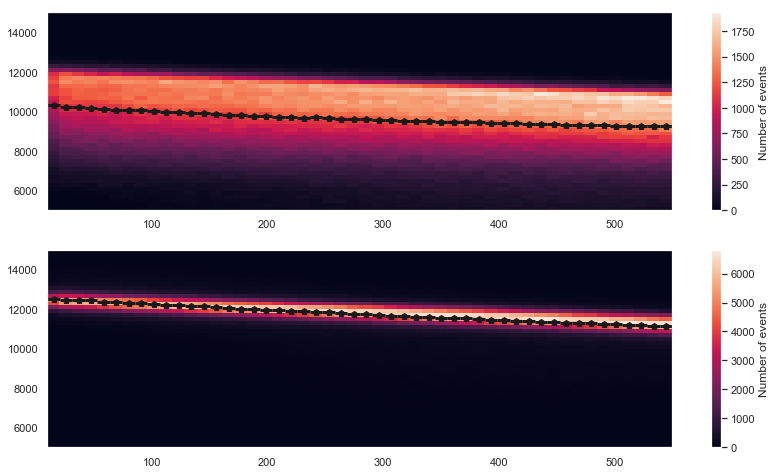

In [429]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)

## XY (single time) LT correction

In [430]:
ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)


Time spent in lt_xy_correction: 12.479519844055176 s


In [431]:
er = (5000,15000)

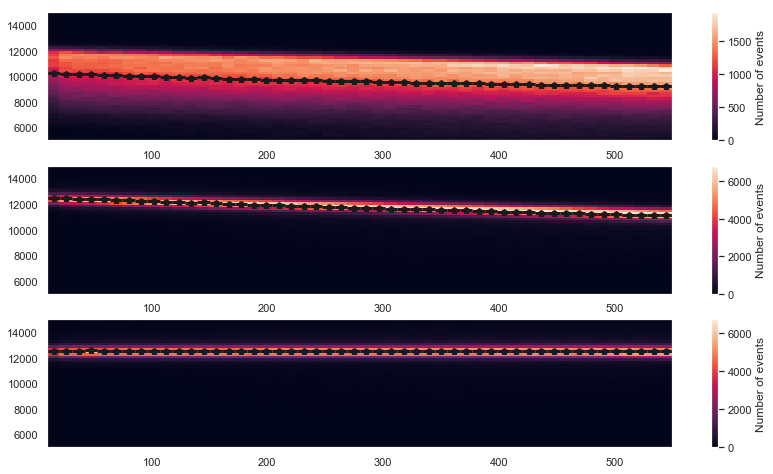

In [432]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.Z, E, 50, 50, krRanges.Z, er, 
           profile=True)

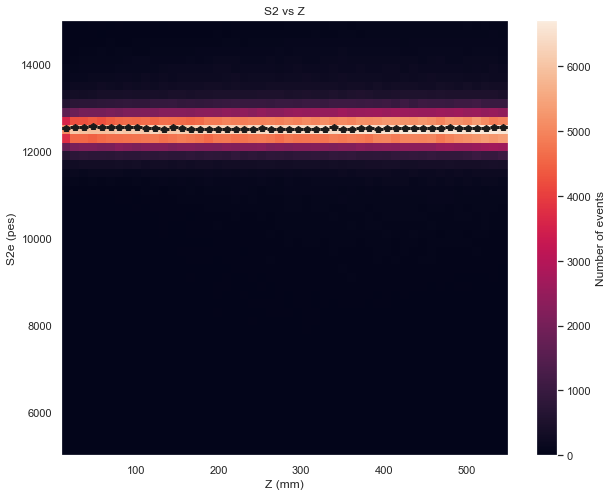

In [433]:
nevt = h2d(dst.Z, E, 50, 50, krRanges.Z, (5000,15000),  
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

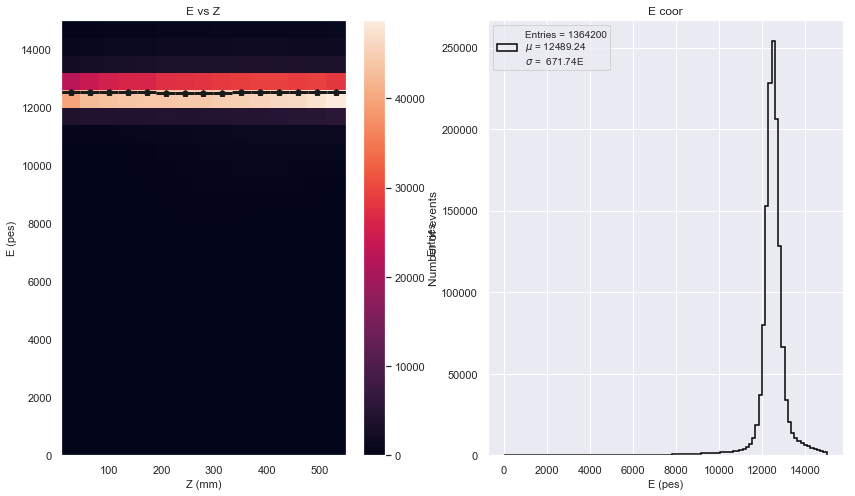

In [434]:
e_range = (0, 15000)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12508.07385161464 +-0.2843685841286038 
 E sigma   = 313.87147781839604 +-0.23241960275347792 
 chi2    = 21.4735309985614 
 sigma E/E (FWHM)     (%) =5.896974878973999
 sigma E/E (FWHM) Qbb (%) =0.761605842131361 


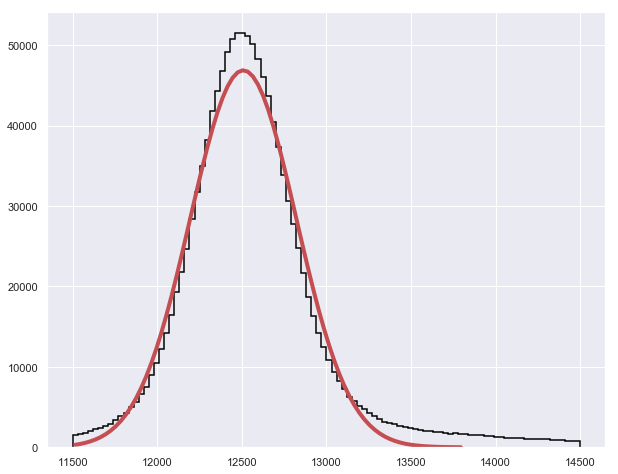

In [435]:
fc = fit_energy(E, nbins=100, range=(11500, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

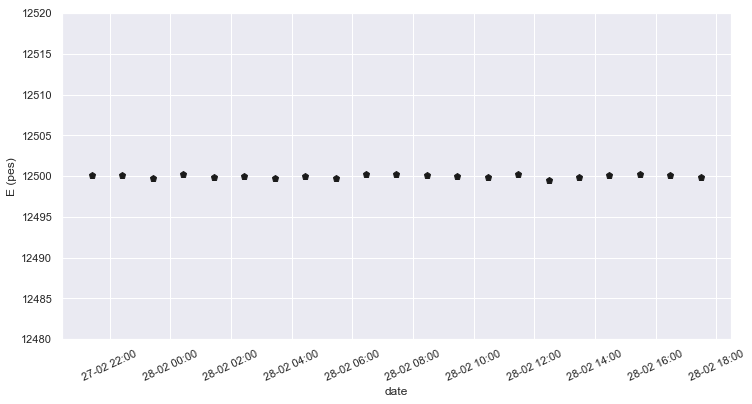

In [436]:
baseline = 12500
shift = 20
e1 = baseline - shift
e2 = baseline + shift
energy_time_profile(T, E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(e1, e2),
                    figsize=(12,6))

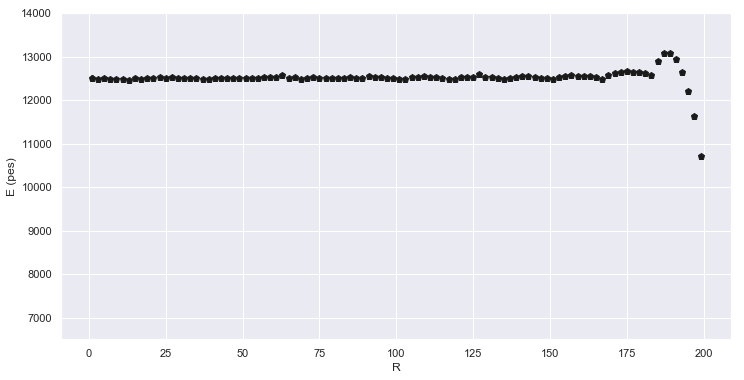

In [437]:
energy_X_profile(dst.R, E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

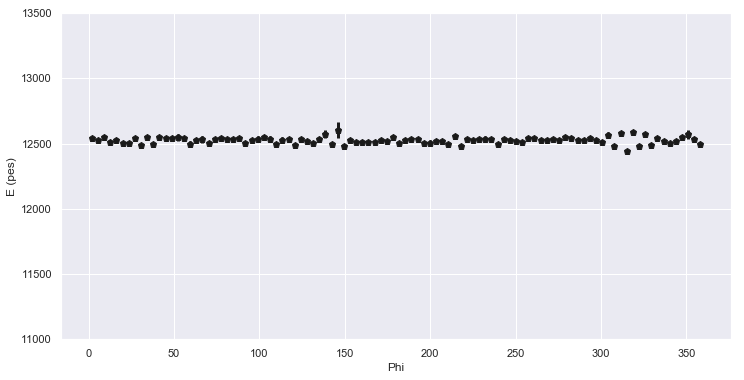

In [438]:
energy_X_profile(phirad_to_deg(dst.Phi), E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13500),  
                 figsize=(12,6))

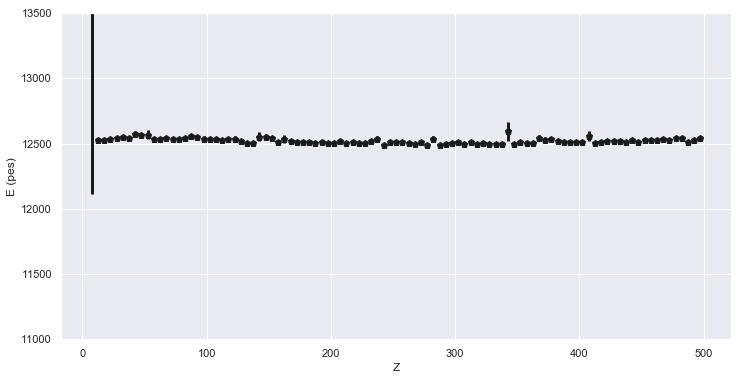

In [439]:
energy_X_profile(dst.Z, E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13500),   
                 figsize=(12,6))

### Select events in the region

- R < 180
- 10 < z < 550
- 11000 < E < 13500

In [440]:
dst = dst.assign(E=E)

In [441]:
RFID = 175
dst_R     = dst[dst.R < RFID]

### Repeat profles

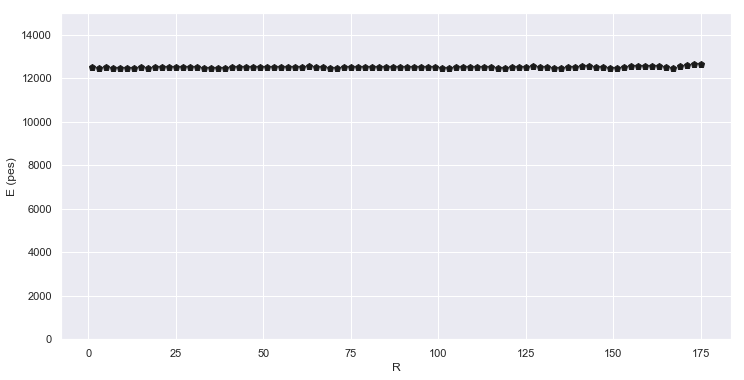

In [442]:
energy_X_profile(dst_R.R, dst_R.E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=e_range,  
                 figsize=(12,6))

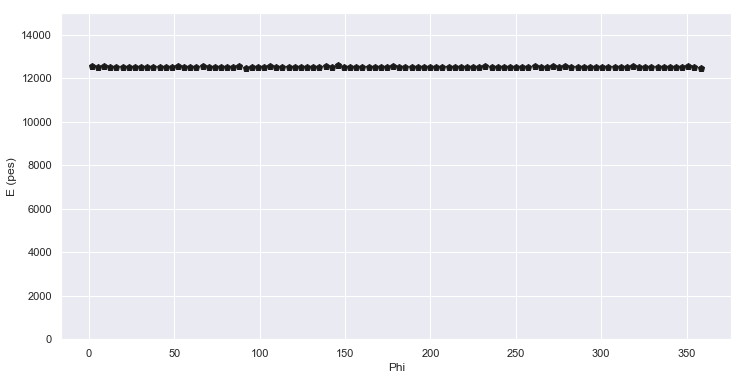

In [443]:
energy_X_profile(phirad_to_deg(dst_R.Phi), dst_R.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=e_range,  
                 figsize=(12,6))

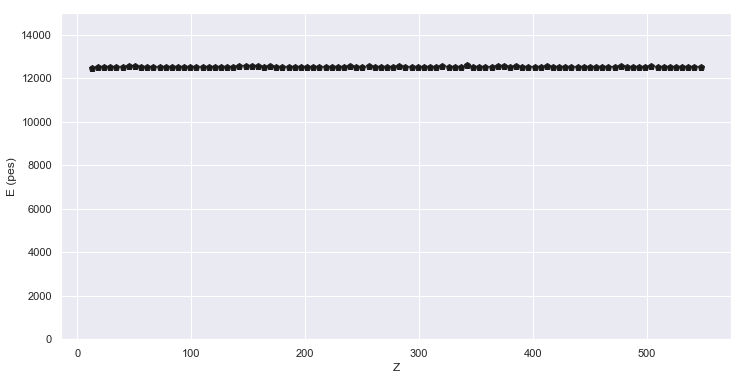

In [444]:
energy_X_profile(dst_R.Z, dst_R.E, xnbins = 100, xrange=zrange, xlabel = 'Z',
                 erange=e_range,   
                 figsize=(12,6))

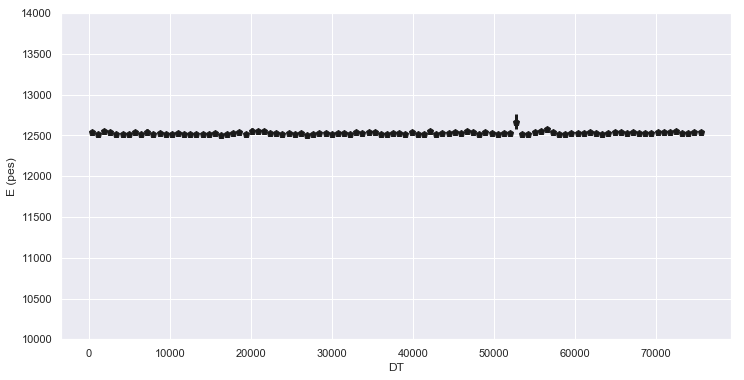

In [445]:
energy_X_profile(dst_R.DT, dst_R.E, xnbins = 100, xrange=(dst_R.DT.values[0], dst_R.DT.values[-1]), xlabel = 'DT',
                 erange=(10000,14000),   
                 figsize=(12,6))

#### Everything is flat. No need for further corrections. 

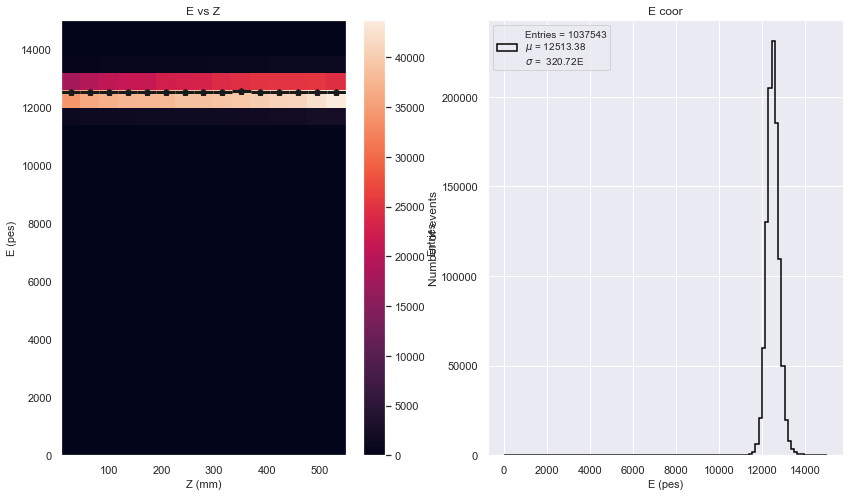

In [446]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst_R.Z, dst_R.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dst_R.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12510.10348713377 +-0.26875870518886935 
 E sigma   = 267.53224174364436 +-0.20798613515935688 
 chi2    = 4.426753250086993 
 sigma E/E (FWHM)     (%) =5.025544103165592
 sigma E/E (FWHM) Qbb (%) =0.6490588526172696 


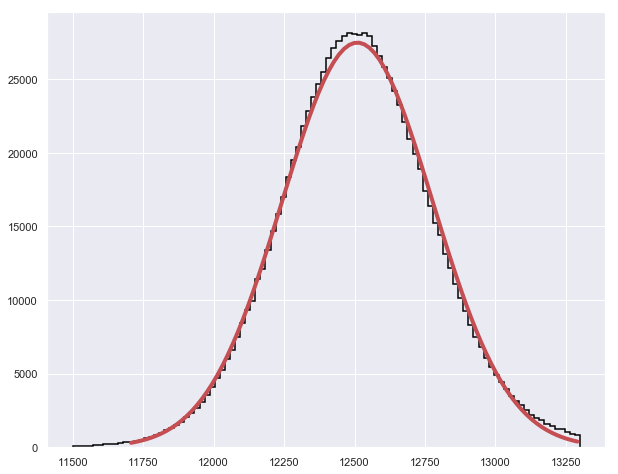

In [447]:
fc = fit_energy(dst_R.E, nbins=100, range=(11500, 13300))
plot_fit_energy(fc)
print_fit_energy(fc)

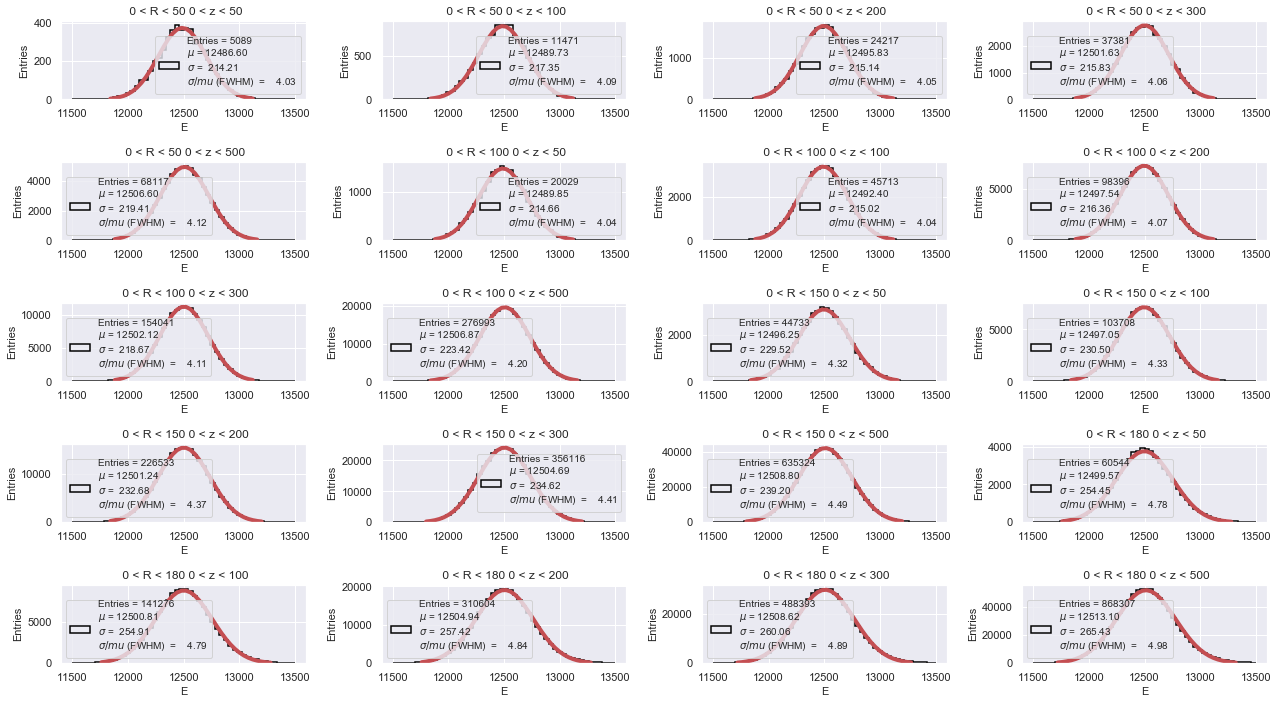

In [448]:
Ri = (50, 100,150,180)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, dst_R.R, dst_R.Z, dst_R.E,
                    enbins = 50,
                    erange = (11500,13500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

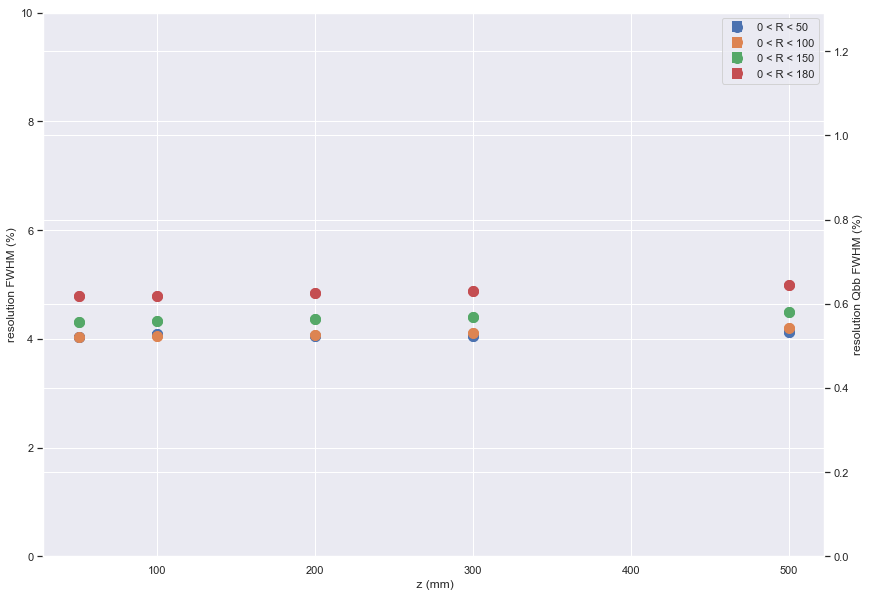

In [449]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(0,10))

## 50 x 50 bins

In [485]:
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 50,
                                                        ynbins    = 50,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [489]:
ti = timeit(select_xy_sectors_df)
KXY2 = ti(dst, krBins.X, krBins.Y)

Time spent in select_xy_sectors_df: 3.0734541416168213 s


In [490]:
nXY2 = event_map_df(KXY2)

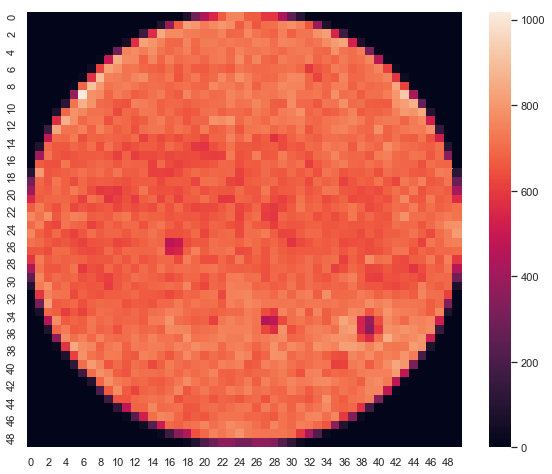

In [491]:
ax = sns.heatmap(nXY2, square=True)

In [492]:
ti = timeit(fit_map_xy_df)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy2 = ti(selection_map = KXY2,
              event_map      = nXY2,
              n_time_bins    = 1,
              time_diffs     = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy         = 'S2e',
              z              = 'Z',
              fit            = FitType.unbined,
              n_min          = 100)

Time spent in fit_map_xy_df: 6.6841583251953125 s


In [493]:
ti = timeit(tsmap_from_fmap)
tsm2 = ti(fmxy2)

Time spent in tsmap_from_fmap: 0.0017740726470947266 s


In [494]:
am2 = amap_from_tsmap(tsm2, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [495]:
rmap2 = regularize_maps(am2, erange=e_range, ltrange=lt_range)

2019-03-02 16:28:14,518 | INFO :  set nans to average value of interval = 10000.0
2019-03-02 16:28:14,570 | INFO :  set nans to average value of interval = 5000.0


In [496]:
amap_average(rmap2)

ASectorMap(chi2=1.1328689051250986, e0=10005.939721592544, lt=4584.136756735109, e0u=41.88421334423362, ltu=200.94654895921914, mapinfo=None)

In [497]:
asm2 = relative_errors(rmap2)

In [498]:
amv2 = amap_average(asm2)
amv2

ASectorMap(chi2=1.1328689051250986, e0=10005.939721592544, lt=4584.136756735109, e0u=0.4660956459427576, ltu=4.705125342949288, mapinfo=None)

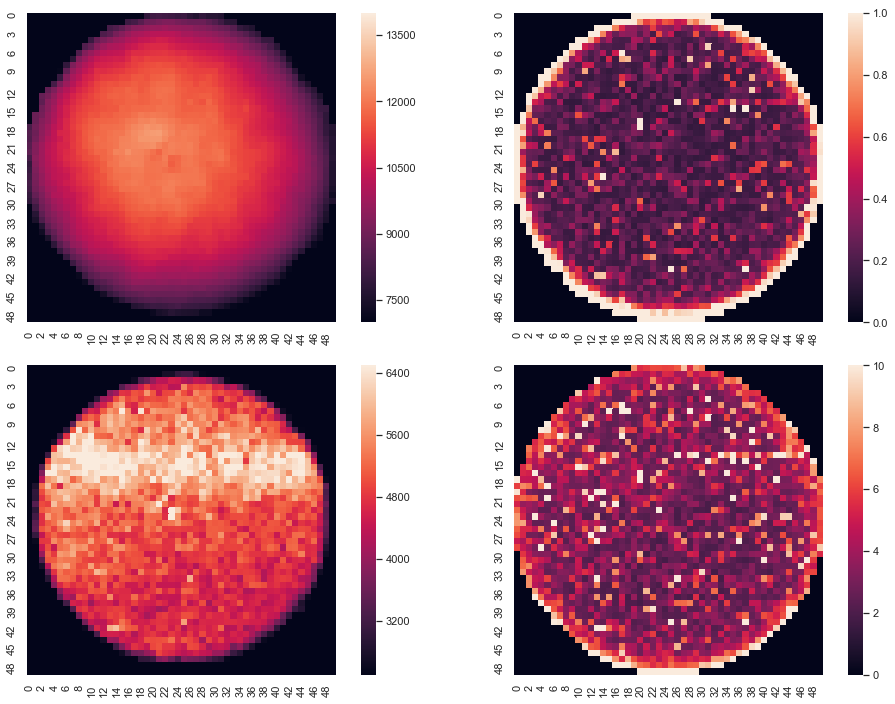

In [499]:
draw_xy_maps(asm2,
            e0lims  = (7000, 14000),
            ltlims  = (2500, 6500),
            eulims  = (0.0,  1),
            lulims  = (0, 10),
            figsize=(14,10))

In [500]:
asmAv2 = amap_replace_nan_by_mean(asm2, amMean=amv2)

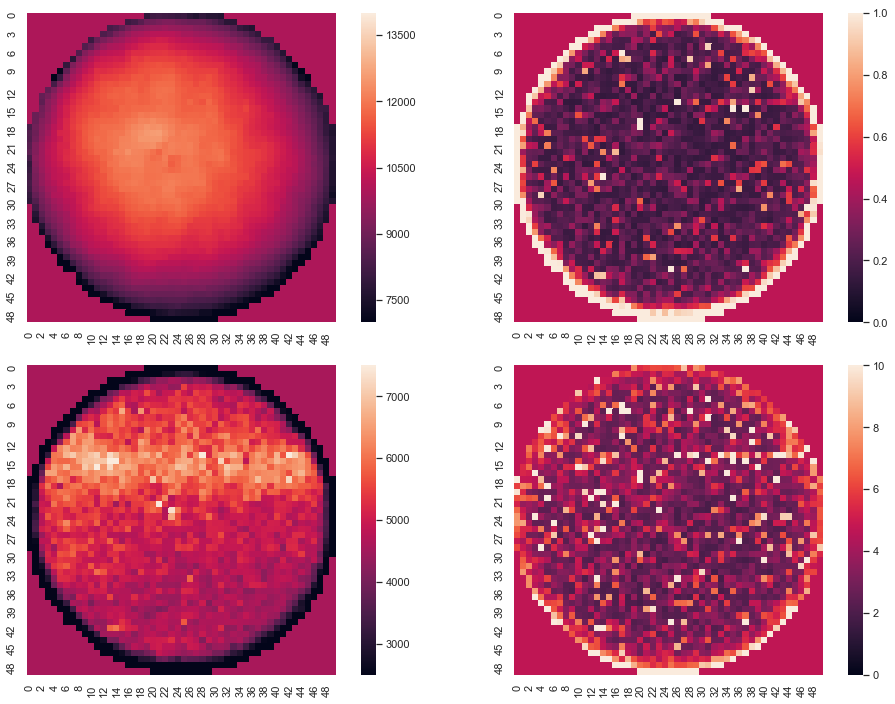

In [501]:
draw_xy_maps(asmAv2,
            e0lims  = (7000, 14000),
            ltlims  = (2500, 7500),
            eulims  = (0.0,  1),
            lulims  = (0, 10),
            figsize=(14,10))

In [502]:
asm2 = add_mapinfo(asmAv2, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number=6973)

In [503]:
emaps2 = asm2

In [504]:
norm2 = amap_max(emaps2)

In [505]:
norm2

ASectorMap(chi2=5.098537355067377, e0=12605.754659409773, lt=8337.52455153415, e0u=4.824747975228987, ltu=39.87794956720433, mapinfo=None)

In [506]:
ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps2.e0 / norm2.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 12.42430305480957 s


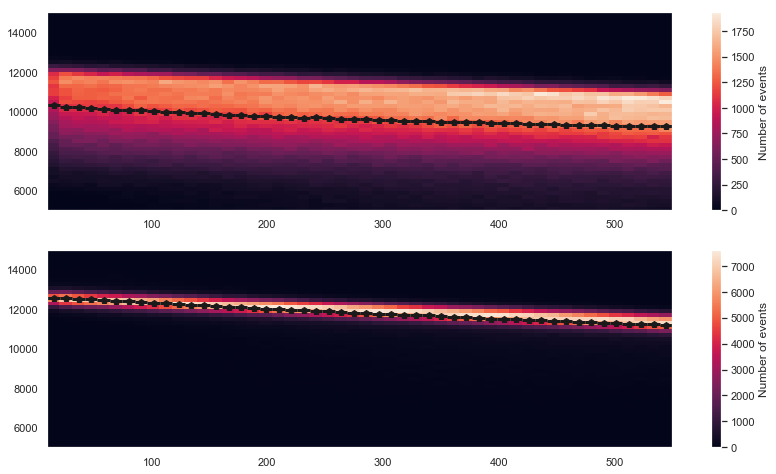

In [507]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)

In [508]:
ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps2.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)

Time spent in lt_xy_correction: 12.308235168457031 s


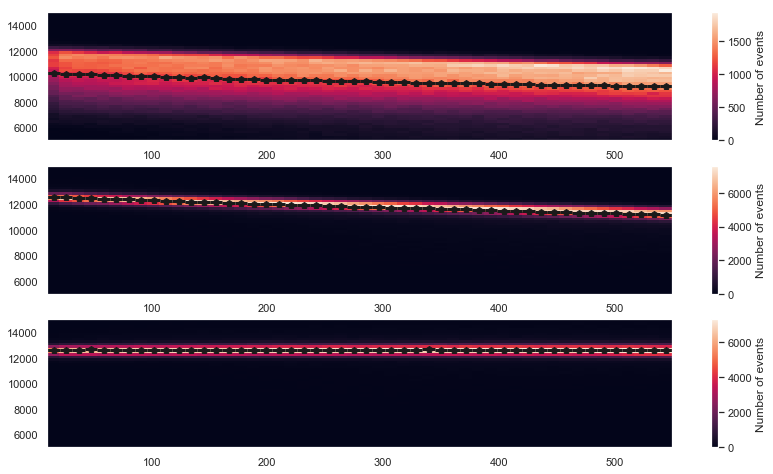

In [509]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.Z, E, 50, 50, krRanges.Z, er, 
           profile=True)

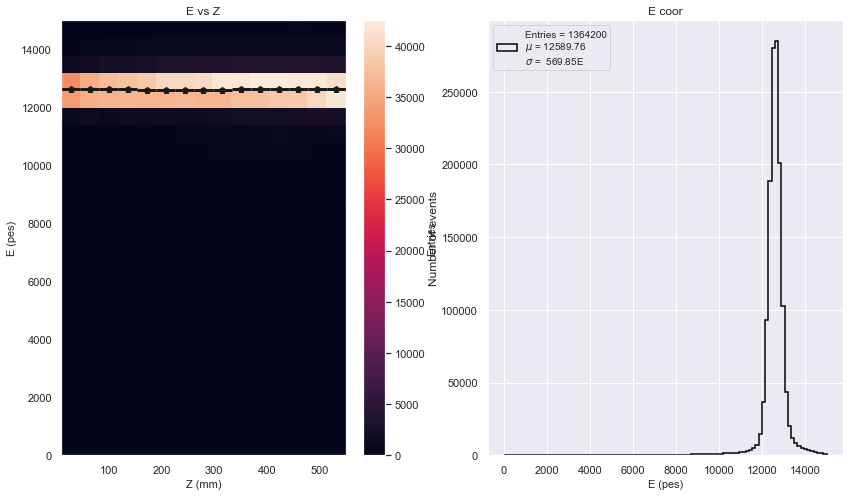

In [510]:
e_range = (0, 15000)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12611.840358381754 +-0.2403414237924152 
 E sigma   = 270.4513455139338 +-0.1901678173794438 
 chi2    = 18.146926981114415 
 sigma E/E (FWHM)     (%) =5.039396661371111
 sigma E/E (FWHM) Qbb (%) =0.6508479376098825 


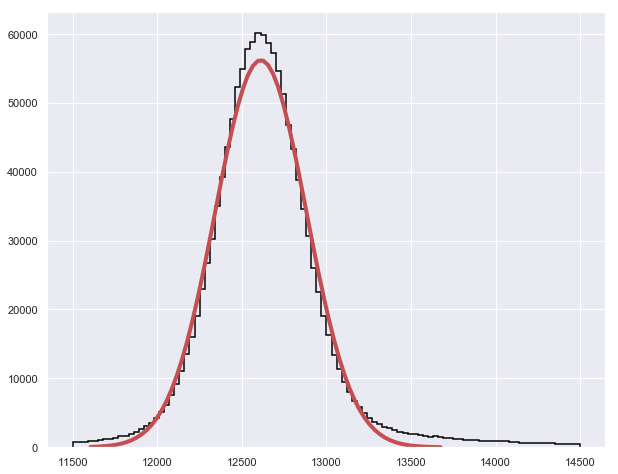

In [511]:
fc = fit_energy(E, nbins=100, range=(11500, 14500))
plot_fit_energy(fc)
print_fit_energy(fc)

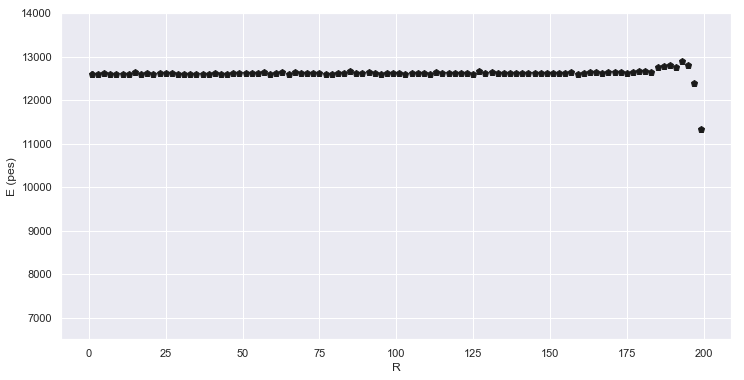

In [512]:
energy_X_profile(dst.R, E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

In [514]:
RFID = 175
dst = dst.assign(E2=E)
dst_R     = dst[dst.R < RFID]

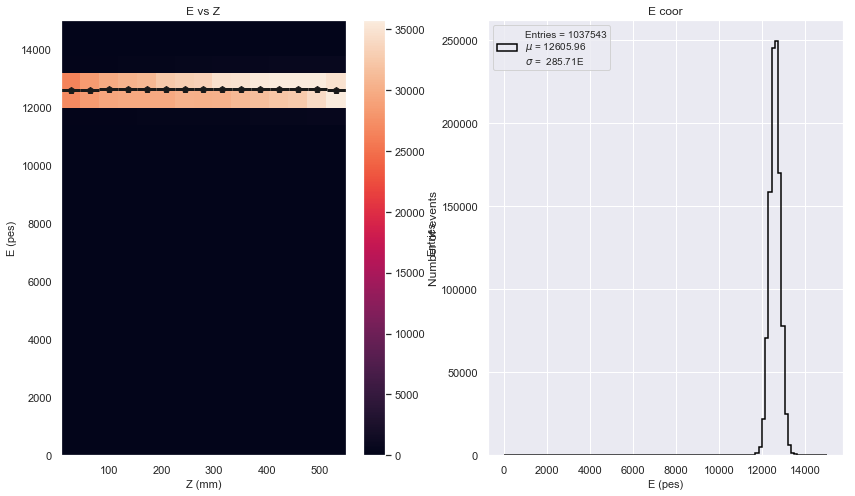

In [515]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst_R.Z, dst_R.E2, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dst_R.E2,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12608.160737523258 +-0.23569640586026086 
 E sigma   = 235.4759836846094 +-0.17969705780371692 
 chi2    = 1.9406125256071058 
 sigma E/E (FWHM)     (%) =4.388971343075815
 sigma E/E (FWHM) Qbb (%) =0.5668442352963269 


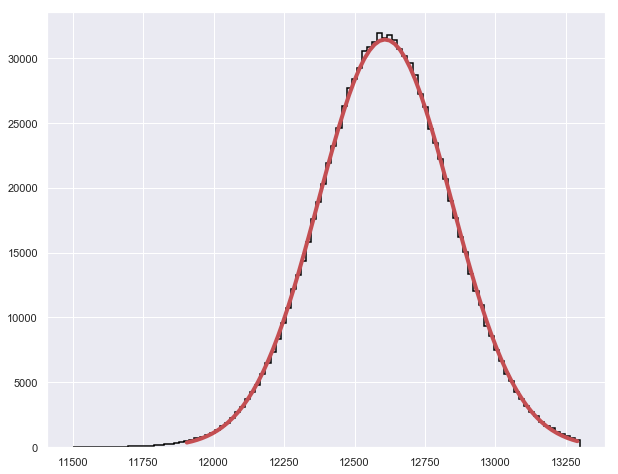

In [516]:
fc = fit_energy(dst_R.E2, nbins=100, range=(11500, 13300))
plot_fit_energy(fc)
print_fit_energy(fc)

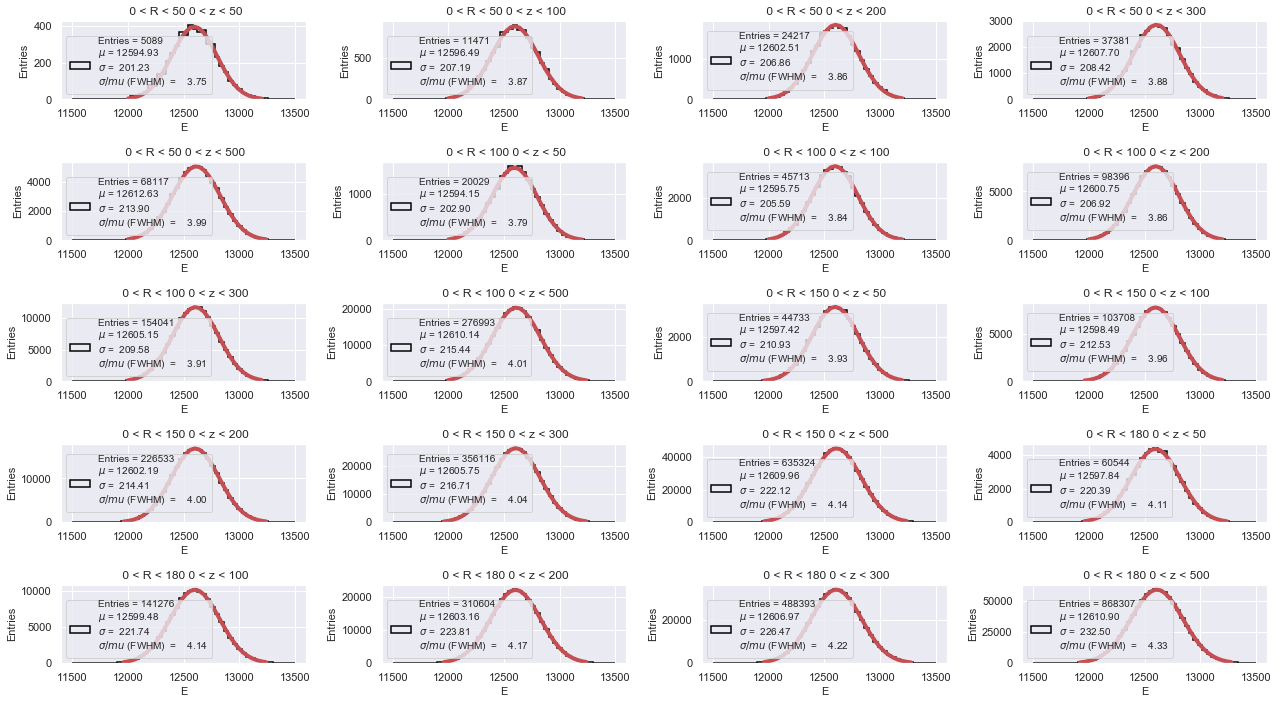

In [518]:
Ri = (50, 100,150,180)
Zi = (50, 100,200,300,500)

FC2, FCE2 = resolution_r_z(Ri, Zi, dst_R.R, dst_R.Z, dst_R.E2,
                    enbins = 50,
                    erange = (11500,13500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

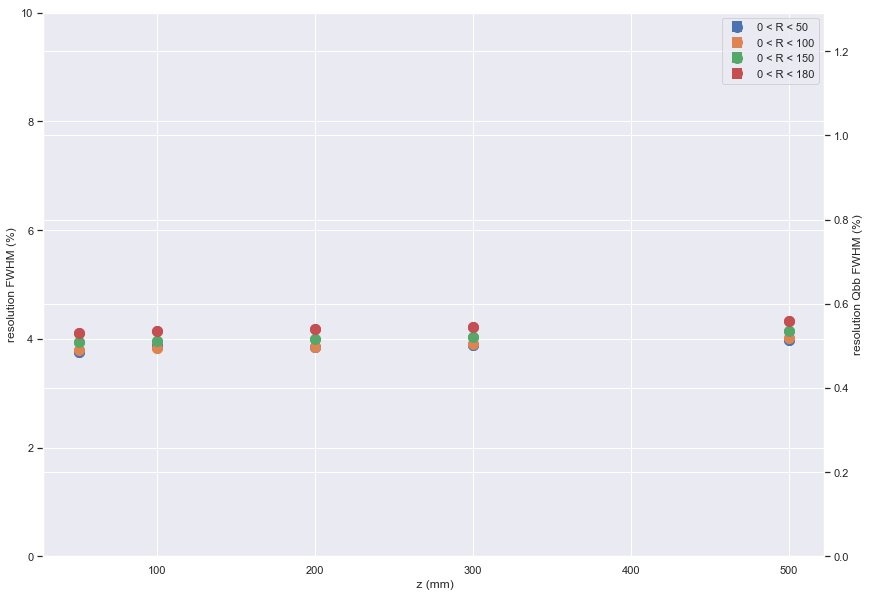

In [519]:
plot_resolution_r_z(Ri, Zi, FC2, FCE2, r_range=(0,10))

## 100 x 100 bins

## Now repeat the exercize for ZRms

In [124]:
dst = dst_R

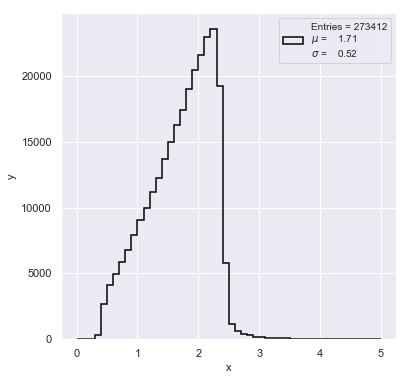

In [125]:
(_) = h1d(dst.Zrms, bins = 50, range =(0,5))

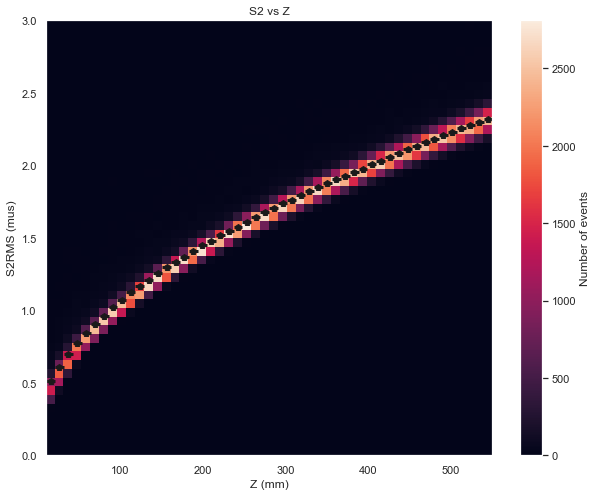

In [126]:
nevt = h2d(dst.Z, dst.Zrms, 50, 50, (10,550), (0,3), 
           pltLabels=PlotLabels(x='Z (mm)', y='S2RMS (mus)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

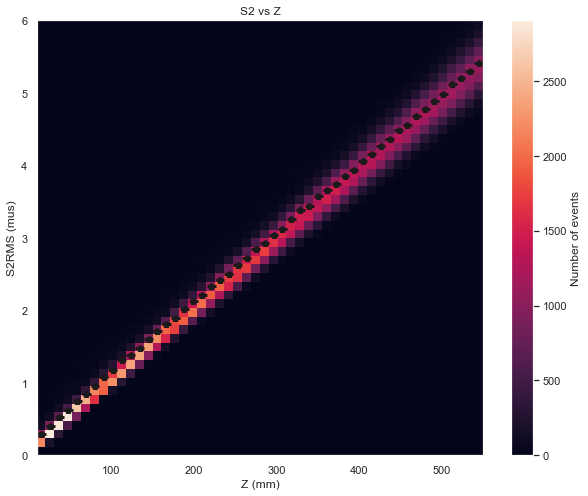

In [127]:
nevt = h2d(dst.Z, dst.Zrms * dst.Zrms, 50, 50, (10,550), (0,6), 
           pltLabels=PlotLabels(x='Z (mm)', y='S2RMS (mus)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [128]:
x, y, yu  = profile1d(dst.Z, dst.Zrms * dst.Zrms, 20, range_z=(50, 500))

In [129]:
fh     = fitf.fit(fitf.polynom, x, y, seed=(1,1), fit_range=(10,500), sigma=0.005*y)

In [130]:
fh

FitFunction(fn=<function fit.<locals>.<lambda> at 0x1a26d64950>, values=array([0.1967706, 0.0095995]), errors=array([3.58332954e-03, 2.04790538e-05]), chi2=2.3677247412656017, pvalue=0.0009055933389397857, cov=array([[ 1.28402506e-05, -6.00186274e-08],
       [-6.00186274e-08,  4.19391643e-10]]))

Text(0, 0.5, 'Zrms2')

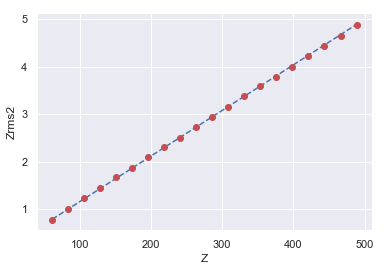

In [131]:
plt.errorbar(x, y,  yerr=0.01*y, fmt='ro')
plt.plot(x, fh.fn(x), 'b--')
plt.xlabel('Z')
plt.ylabel('Zrms2')

In [132]:
def z_from_s2rms(s2rms : np.array,  fh)->np.array:
    zr = (s2rms * s2rms - fh.values[0]) / fh.values[1]
    return zr 

In [133]:
zs2 = z_from_s2rms(dst.Zrms, fh)

In [134]:
dst = dst.assign(ZS2=zs2)

In [135]:
dst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms', 'E', 'ZS2'],
      dtype='object')

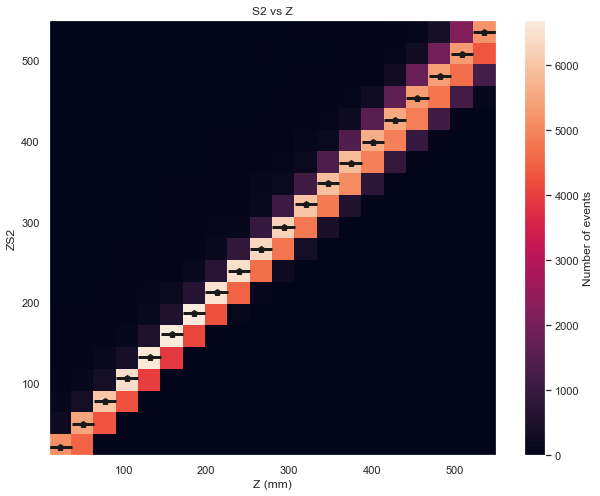

In [136]:
nevt = h2d(dst.Z, dst.ZS2, 20, 20, (10,550), (10,550), 
           pltLabels=PlotLabels(x='Z (mm)', y='ZS2', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

### Maps using Zrms

In [137]:
ti = timeit(select_xy_sectors_df)
KXY2 = ti(dst, krBins.X, krBins.Y)

Time spent in select_xy_sectors_df: 2.130129814147949 s


In [138]:
ti = timeit(fit_map_xy_df)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy = ti(selection_map = KXY2,
              event_map      = nXY,
              n_time_bins    = 1,
              time_diffs     = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy         = 'S2e',
              z              = 'ZS2',
              fit            = FitType.unbined,
              n_min          = 100)

2019-03-01 10:12:08,040 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-03-01 10:12:08,042 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-03-01 10:12:08,044 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-03-01 10:12:08,045 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-03-01 10:12:08,047 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-03-01 10:12:08,049 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-03-01 10:12:08,051 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-03-01 10:12:08,053 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-03-01 10:12:08,056 | WARNING : Type error found in fit_lifetime_unbined: not enough events for fit
2019-03-01 10:12:08,058 | WARNING : Type error found in fit_life

In [139]:
ti = timeit(tsmap_from_fmap)
tsm = ti(fmxy)

Time spent in tsmap_from_fmap: 0.0016129016876220703 s


In [140]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)
amap_average(am) 

ASectorMap(chi2=1.7118579467633699, e0=10334.956251303385, lt=5773.491002653524, e0u=45.59600252809639, ltu=7292.5447470475865, mapinfo=None)

In [141]:
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range)
amap_average(rmap)
asm = relative_errors(rmap)
amv = amap_average(asm)
amv

2019-03-01 10:12:42,770 | INFO :  set nans to average value of interval = 7500.0
2019-03-01 10:12:42,821 | INFO :  set nans to average value of interval = 3500.0


ASectorMap(chi2=1.7118579467633699, e0=10334.956251303385, lt=5108.725403689274, e0u=0.4482212650186494, ltu=5.87975579768491, mapinfo=None)

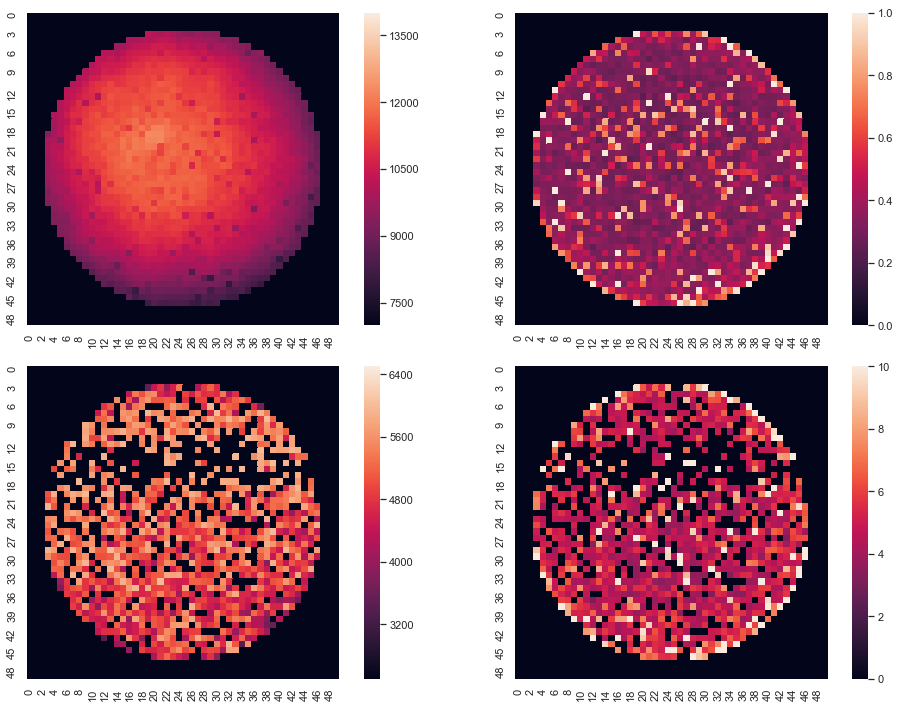

In [142]:
draw_xy_maps(asm,
            e0lims  = (7000, 14000),
            ltlims  = (2500, 6500),
            eulims  = (0.0,  1),
            lulims  = (0, 10),
            figsize=(14,10))

In [119]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number=-6400)

In [121]:
norm = amap_max(asm)

In [122]:
norm

ASectorMap(chi2=4.726677844623, e0=13188.162174220006, lt=5885.775261843065, e0u=2.7939829484426393, ltu=22.603621256789708, mapinfo=None)

In [143]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

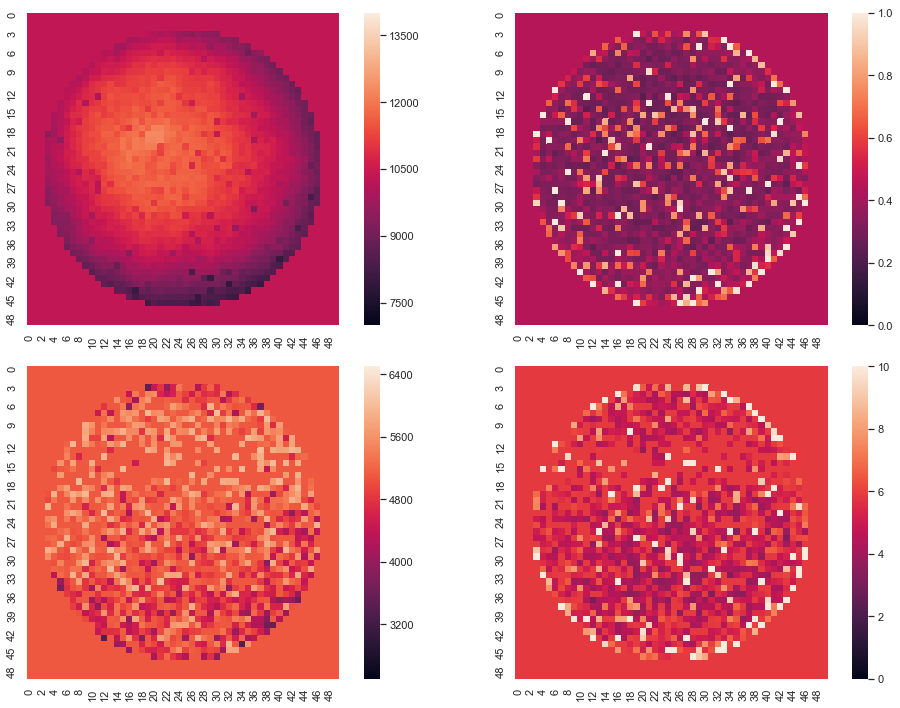

In [144]:
draw_xy_maps(asmAv,
            e0lims  = (7000, 14000),
            ltlims  = (2500, 6500),
            eulims  = (0.0,  1),
            lulims  = (0, 10),
            figsize=(14,10))

In [145]:
norm = amap_max(asmAv)

In [146]:
norm

ASectorMap(chi2=248.64767755870645, e0=12298.31627702283, lt=5998.293756834988, e0u=5.09626404146214, ltu=39.82813348797719, mapinfo=None)

In [147]:
ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = asm.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 2.579822063446045 s


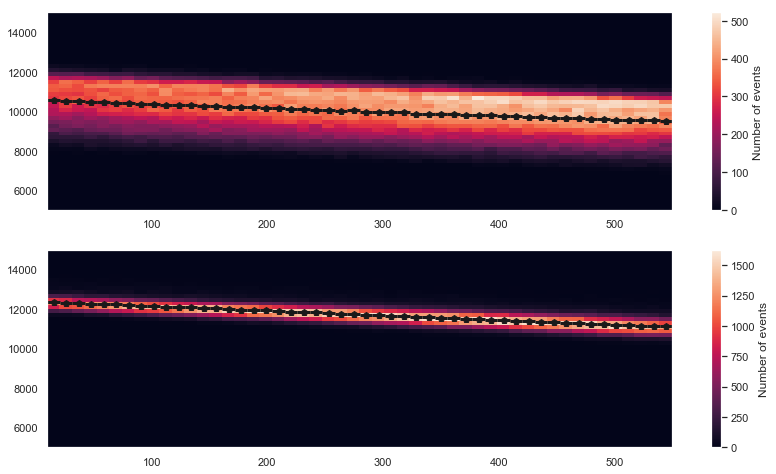

In [148]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.ZS2, dst.S2e, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.ZS2, E0, 50, 50, krRanges.Z, (5000,15000), 
           profile=True)

In [149]:
ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.ZS2.values, 
       LTM = asm.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)


Time spent in lt_xy_correction: 2.6148438453674316 s


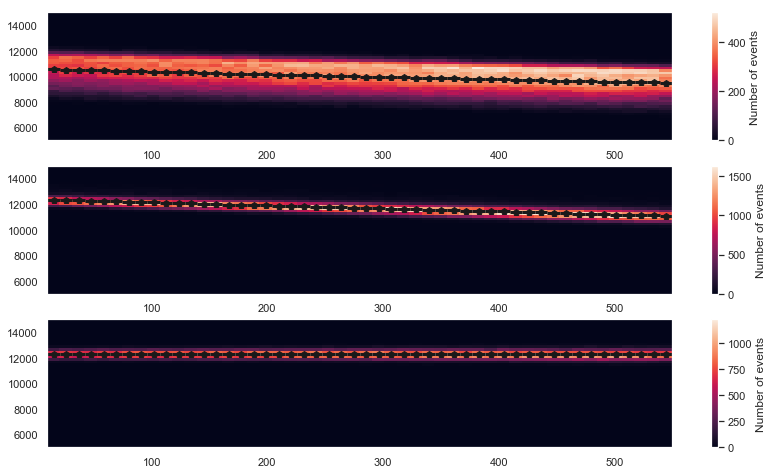

In [150]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.ZS2, dst.S2e, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.ZS2, E0, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.ZS2, E, 50, 50, krRanges.Z, er, 
           profile=True)

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


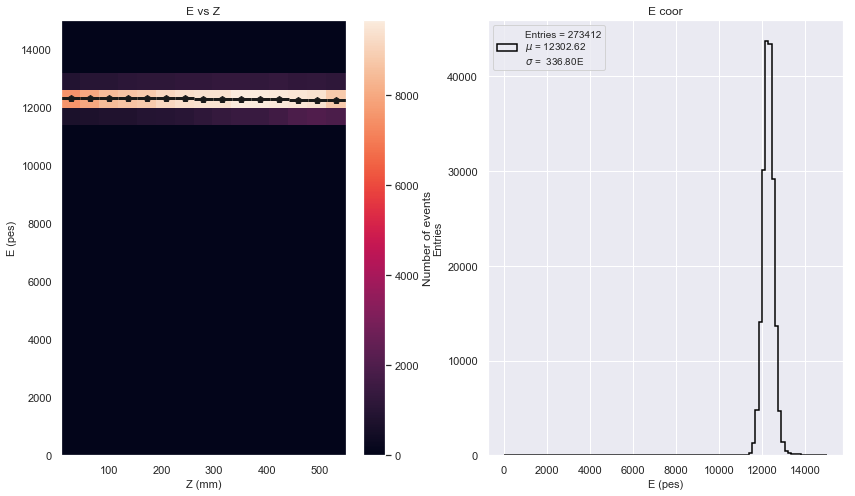

In [151]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.ZS2, E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12297.319360468035 +-0.5721776044153373 
 E sigma   = 243.57235990241574 +-0.43550282234641136 
 chi2    = 1.2118918631345155 
 sigma E/E (FWHM)     (%) =4.654632680442087
 sigma E/E (FWHM) Qbb (%) =0.6011549167421645 


/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in less
  return (minval <= data) & (data < maxval)
/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


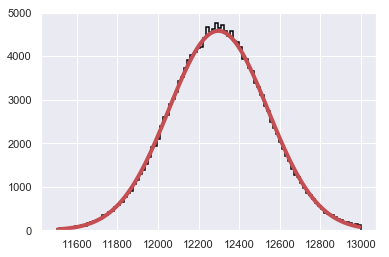

In [155]:
fc = fit_energy(E, nbins=100, range=(11500, 13000))
plot_fit_energy(fc)
print_fit_energy(fc)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in less
  return (minval <= data) & (data < maxval)
/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/core_func

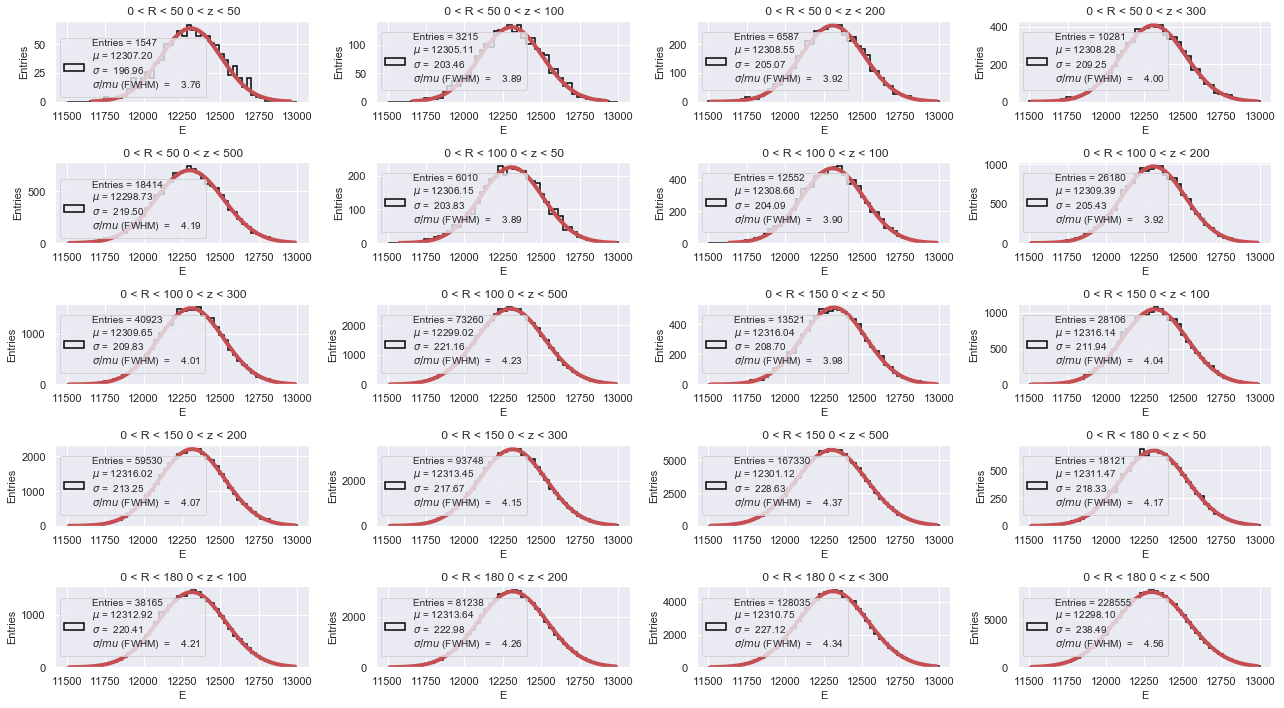

In [156]:
FC2, FCE2 = resolution_r_z(Ri, Zi, dst.R, dst.ZS2, E,
                    enbins = 50,
                    erange = (11500,13000),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

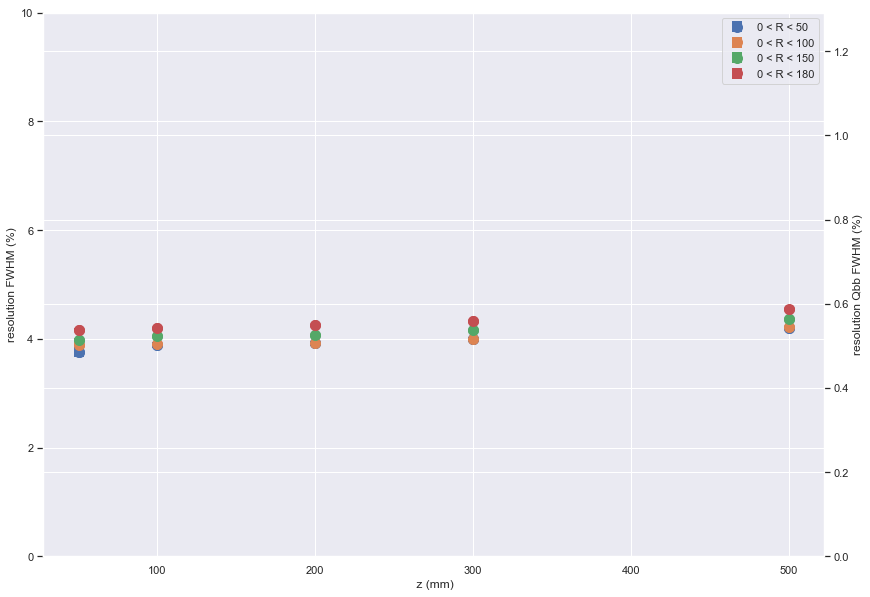

In [157]:
plot_resolution_r_z(Ri, Zi, FC2, FCE2, r_range=(0,10))

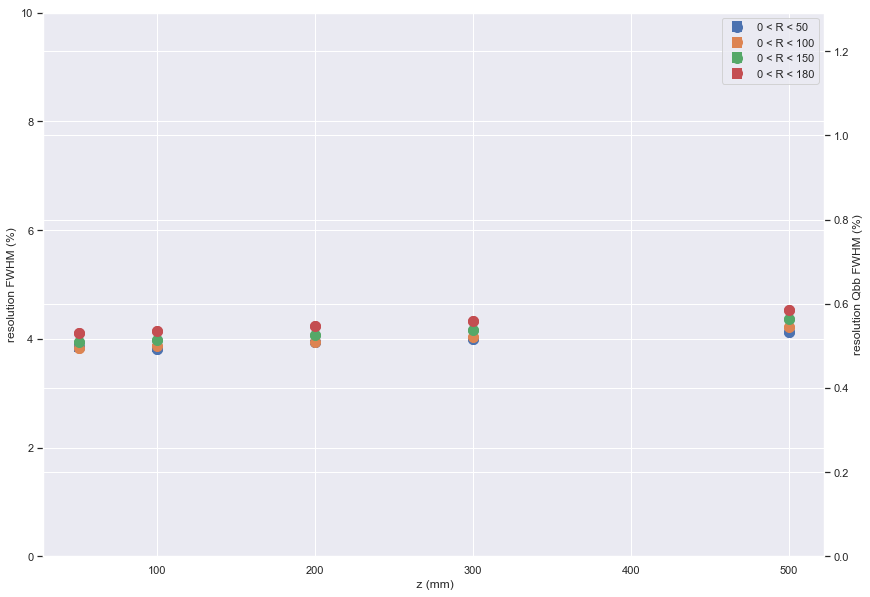

In [161]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(0,10))